<a href="https://colab.research.google.com/github/anaguilarar/WeatherSoilDataProcessor/blob/main/google_colab_examples/dssat_spatial_crop_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run site-specific spatial Crop Simulation using region of interest

In this example, we aim to simulate the potential yield of a specific crop for a defined region of interest. The simulation requires detailed information about soil and weather conditions, as well as the management practices used.

In a previous example, we explained how to download soil and climate data from global spatial products such as CHIRPS and save them as NetCDF files.

For this module, a configuration file is required to specify the type of experiment the user intends to implement. This file contains the necessary parameters to guide the simulation process.


In [1]:
!git clone https://github.com/anaguilarar/WeatherSoilDataProcessor.git

import os
os.chdir('/content/WeatherSoilDataProcessor')

!git clone https://github.com/anaguilarar/Py_DSSATTools.git

!pip install -r /content/WeatherSoilDataProcessor/requirements.txt

Cloning into 'WeatherSoilDataProcessor'...
remote: Enumerating objects: 2208, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 2208 (delta 61), reused 68 (delta 19), pack-reused 2082 (from 2)
Receiving objects: 100% (2208/2208), 124.43 MiB | 11.28 MiB/s, done.
Resolving deltas: 100% (1748/1748), done.
Updating files: 100% (76/76), done.
Cloning into 'Py_DSSATTools'...
remote: Enumerating objects: 1149, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 1149 (delta 203), reused 192 (delta 192), pack-reused 930 (from 1)
Receiving objects: 100% (1149/1149), 18.21 MiB | 7.43 MiB/s, done.
Resolving deltas: 100% (795/795), done.
Updating files: 100% (226/226), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.1 MB/s eta 0:

## Crop modeling

Once the spatial data has been configured, the next step is to define the site-specific management unit. In this example, the management unit is defined by a combination of political division (village boundaries) and soil textural classification.

To specify political data, you can use the name of a feature in the geospatial file. For further spatial deatail, soil texture is used to gain a btter knowledge. Currently texture is the only grouping option available.

Other parameters to configure include crop parameters and management practices. Below is an example of how to define these parameters. For more examples, please check the options/dssat_options folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tarfile
path_to_zip_file = '/content/DSSAT048.tar.gz'
directory_to_extract_to = '/content/'
tar = tarfile.open(path_to_zip_file, 'r:gz')
tar.extractall(directory_to_extract_to)
tar.close()

In [1]:
import os
os.chdir('/content/WeatherSoilDataProcessor')
import sys
sys.path.append("/content/WeatherSoilDataProcessor/Py_DSSATTools/")
from spatialdata.soil_data import TEXTURE_CLASSES
from crop_modeling.spatial_process import SpatialCM

cm_configuration = {
    'GENERAL_INFO': {
        'country': 'Honduras',
        'country_code': 'HND', # crountry code
        'working_path': 'runs', # the model outputs will be located in this path
        'ncores': 0,
        'model': 'dssat',
        'bin_path': '/content/DSSAT048/dscsm048',
        'dssat_path': '/content/DSSAT048/'
    },
    'SPATIAL_INFO':{
        'geospatial_path': 'data/tb_limitealdeas.shp', # spatial file that contains the region of interest
        'feature_name': 'GEOCODIGO', ## an unique code that represent each region of interest
        'aggregate_by' : 'texture',
        'soil_path' : '/content/drive/MyDrive/CIAT/agwise/hnd_soilgrids_data.nc',
        'weather_path': '/content/drive/MyDrive/CIAT/agwise/climate_1990_2024_data_wnvp_.nc',
        'scale_factor': 10 # scale factor for soil and weather spatial resolution combination
    },
    'CROP': {
        'name': 'Maize', # crop name
        'cultivar': 'IB1072', # cultivar
        'cultivar_file': None # optional for the cases that you have a cultivar that is not in DSSATTools default cultivars
    },
    'MANAGEMENT':{
        'planting_date': '2015-02-01',
        'harvesting_date': '2015-06-30',
        'plantingWindow': 35, # planting window in weeks
        'fertilizer_schedule': {
            'days_after_planting': None,
            'npk': None
        }, # It is not implemented yet
        'index_soilwat': 1,
        'template': 'crop_modeling/dssat/exp_files/KEAG8104.MZX'
    }
}



In [2]:
import shutil

shutil.rmtree('/content/WeatherSoilDataProcessor/runs/180110', ignore_errors=False, onerror=None)

In [3]:

import numpy as np
import pandas as pd

# Initialize the spatial crop modeling class
cm_sp = SpatialCM(configuration_dict=cm_configuration)

loaded from /content/drive/MyDrive/CIAT/agwise/hnd_soilgrids_data.nc
loaded from /content/drive/MyDrive/CIAT/agwise/climate_1990_2024_data_wnvp_.nc


In [4]:
# Specify the region of interest by its geocode this can be also done using the feature index
roi = cm_sp.geo_features.loc[cm_sp.geo_features[cm_sp.config.SPATIAL_INFO.feature_name]==str(180110)]
roi_name = roi[cm_sp.config.SPATIAL_INFO.feature_name].values[0]
roi

,GEOCODIGO,ALDEA,COD_ALDEA,COD_MUNI,COD_DEPTO,KM2,DENSIDAD,MUNI,DEPTO,AREA_HA,geometry
1113,180110,La Trinidad,180110,1801,18,139.413,32.2854,Yoro,Yoro,13941.276738,"POLYGON ((-87.36772 15.14419, -87.36869 15.145..."


In [ ]:

# Create soil and weather files for the selected region
cm_sp.set_up_folders(site = roi_name)

workingpath = cm_sp.create_roi_sp_data(
    #roi_index=roi_index,
    roi= roi,
    group_codes=TEXTURE_CLASSES,  # Codes for grouping data by texture
    create_group_splayer=True,  # Option to create a grouped spatial layer
    export_spatial_data=True
)
if workingpath is not None:
    # Locate environmental working paths
    cm_sp.model.find_envworking_paths(cm_sp._tmp_path, 'WTH')

    # Set up crop files
    cm_sp.model.set_up_crop(crop=cm_sp.crop, cultivar=cm_sp.cultivar)

    # Set up management files
    cm_sp.model.set_up_management(crop=cm_sp.crop, cultivar=cm_sp.cultivar, **cm_sp.config.MANAGEMENT)
    dssath_path = cm_sp.config.GENERAL_INFO.get('dssat_path', None)
    # run the simulation
    completed_sims =cm_sp.model.run(cm_sp.model.crop_code, crop=cm_sp.crop,planting_window=cm_sp.config.MANAGEMENT.plantingWindow,
                                    ncores = cm_sp.config.GENERAL_INFO.ncores,parallel_tr = False,
                            bin_path = cm_sp.config.GENERAL_INFO.bin_path, dssat_path = dssath_path, remove_tmp_folder=False)
    print(completed_sims)
else:
    print('there is no information')

## Crop simulation outputs

After completing the simulation, the next step is to generate output plots. Three types of plots are created:

 - Spatial Variable Map: Displays the spatial variable (e.g., soil texture) used to define the specific context.
 - Climate Data Time Series Plot: Shows the time series of the climate data.
 - Potential Yield Plot: Illustrates potential yield across different planting date scenarios.


In [8]:
from crop_modeling.utils.output_transforms import (export_data_ascsv, update_data_using_path,
                                                   yield_data_summarized, ColumnNames)

model_data = update_data_using_path(cm_sp._tmp_path, model = cm_sp.model.name)

In [9]:
export_data_ascsv(completed_sims, model_data, cm_sp.crop.lower(), cm_sp._tmp_path, cm_sp.model.name, weather_variables2export = ['date', 'tmin', 'tmax', 'rain', 'srad'])

In [10]:
from datetime import datetime
## define column names for dssat output
ouput_columns = ColumnNames(cm_sp.model.name)
groupby_colname = 'texture'
group_dates_by = ouput_columns.growth_colnames['number_of_cycle']
date_col_name = ouput_columns.growth_colnames['date']
target_col_name = ouput_columns.growth_colnames['yield']
harvest_col_name = ouput_columns.growth_colnames.get('hdate', None)
weather_date_col_name = ouput_columns.weather_columns['date']
potential_yield_path = os.path.join(workingpath,f'{cm_sp.crop.lower()}_potential_yield.csv')

## read simulation data

outputmodel_data = pd.read_csv(potential_yield_path)[[date_col_name,harvest_col_name,target_col_name,group_dates_by,groupby_colname]].dropna()
weather = pd.read_csv(os.path.join(workingpath,'weather.csv'))

# change date format
weather[weather_date_col_name] = weather[weather_date_col_name].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
outputmodel_data[date_col_name] = outputmodel_data[date_col_name].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
outputmodel_data[harvest_col_name] = outputmodel_data[harvest_col_name].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

## export summarised data

for texture_class, subset in outputmodel_data.groupby([groupby_colname]):
    print(texture_class)
    subset = subset.reset_index()
    yield_data = yield_data_summarized(subset, date_column=date_col_name, yield_column=target_col_name, harvest_column=harvest_col_name)
    yield_data[~np.isnan(yield_data['y_upper'])].rename(columns={target_col_name:'y'}).to_csv(os.path.join(workingpath, f'yield_data_{texture_class[0]}.csv'))



('clay',)
('clayloam',)


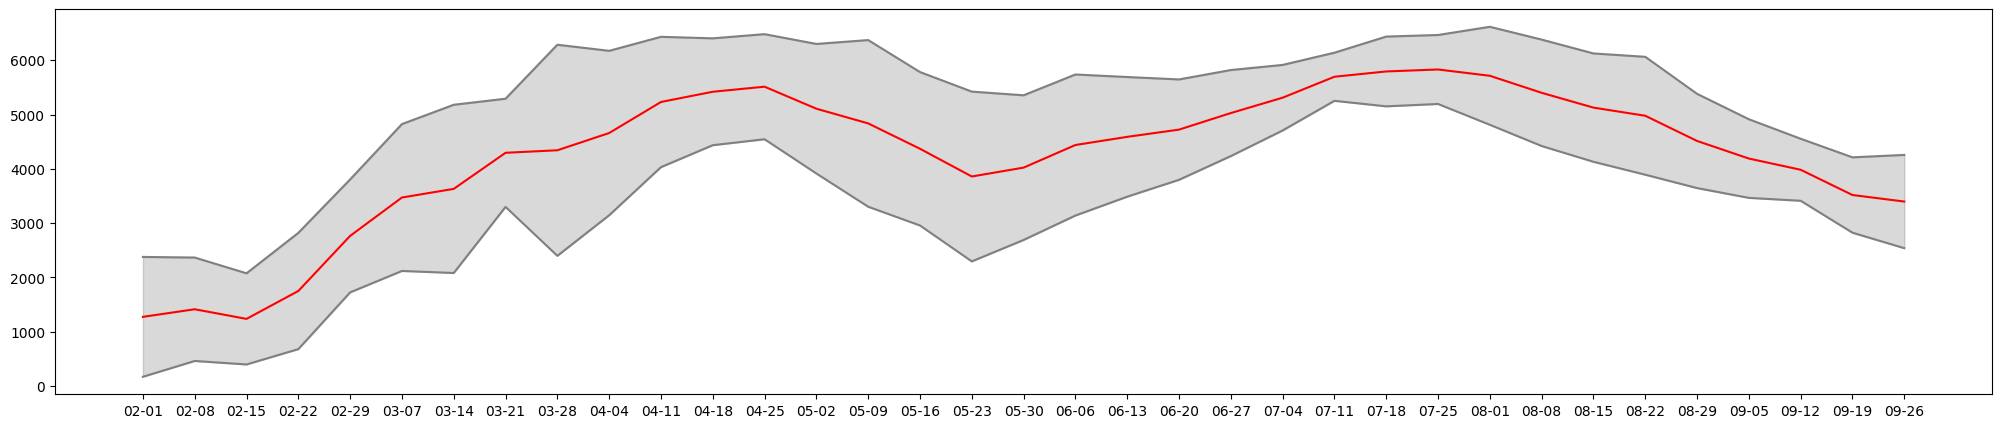

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,5))
plt.plot(yield_data.month_day.values, yield_data[target_col_name].values, c = 'r')
plt.plot(yield_data.month_day.values, yield_data.y_lower.values, c ='gray')
plt.plot(yield_data.month_day.values, yield_data.y_upper.values, c ='gray')
plt.fill_between(list(range(len(yield_data[target_col_name].values))), yield_data.y_upper.values, yield_data.y_lower.values, color="k", alpha=0.15)


In [ ]:
## texture layer
from spatialdata.gis_functions import xrarray_to_categorical_polygon
import rioxarray
import plotly.graph_objects as go

## convert from tif to vector format
textdata = rioxarray.open_rasterio(os.path.join(cm_sp._tmp_path, "texture.tif"))
textdata = textdata.where(textdata < 1.79769313e38, np.nan)
texture_geo = xrarray_to_categorical_polygon(textdata.isel(band=0), "band_data")
texture_geo = texture_geo.rename(columns={"band_data": "texture"})
texture_geo["texture"] = texture_geo["texture"].map(lambda x: TEXTURE_CLASSES[int(x)])

texture_geo = texture_geo.to_crs('EPSG:4326')

x = np.mean(texture_geo.get_coordinates().x.values)
y = np.mean(texture_geo.get_coordinates().y.values)
fig = px.choropleth_map(
    texture_geo,
    geojson=texture_geo,
    color="texture", locations="texture", featureidkey="properties.texture", opacity=0.5,
    zoom=10, center={"lat": y, "lon": x},
)
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin=dict(l=20, r=20, t=5, b=5))

/content/WeatherSoilDataProcessor/spatialdata/gis_functions.py:71: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_subsetdf = geo_subsetdf.buffer(res_sp, cap_style="square")
/content/WeatherSoilDataProcessor/spatialdata/gis_functions.py:71: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_subsetdf = geo_subsetdf.buffer(res_sp, cap_style="square")


In [ ]:
## weather plot

labels = {'RAIN': "Precipitation (mm) <br>Temperature (°C)", "monthday": "Date" }
weatherdatatoviz =output_data['clay'].weather_data()

weatherdatatoviz['year'] = weatherdatatoviz.DATE.dt.year

weatherdatatoviz["TMIN"] = weatherdatatoviz["TMIN"].map(lambda x: float(x))
weatherdatatoviz["TMAX"] = weatherdatatoviz["TMAX"].map(lambda x: float(x))
weatherdatatoviz = pd.melt(weatherdatatoviz.loc[:,['DATE','year', 'TMIN', 'TMAX','RAIN']], id_vars=['DATE','year','RAIN'], value_vars=['TMIN','TMAX'])
weatherdatatoviz['monthday'] = weatherdatatoviz.DATE.dt.strftime('%b-%d')

figwt = px.line(weatherdatatoviz, x="monthday", y="value", animation_frame="year",color = 'variable')
weatherdatatoviz = weatherdatatoviz.loc[weatherdatatoviz.variable == 'TMIN']
weatherdatatoviz.loc[:,'Variable'] = 'Precipitation'
figwr = px.bar(weatherdatatoviz, x="monthday", y="RAIN", animation_frame="year",color = 'Variable',
                        labels = labels)

figw = go.Figure(
    data=figwt.data + figwr.data,
    frames=[
        go.Frame(data=fr1.data + fr2.data, name=fr1.name)
        for fr1, fr2 in zip(figwt.frames, figwr.frames)
    ],
    layout=figwr.layout,
)
figw.show()

.WTH


<ipython-input-10-63a003927c5c>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
## potential yield
labels = {'HWAH': "Yield at harvest (Kg / ha)", "monthday": "Planting Date" }
completedgroups = [k for k,v in completed_sims.items() if v]
potentialyield_data = []
for gval in completedgroups:
    dftmp = output_data[gval].output_data().sort_values("PDAT").loc[:,["PDAT","HWAH"]]
    dftmp = dftmp.loc[dftmp.HWAH != 0]
    dftmp['texture'] = gval
    potentialyield_data.append(dftmp)

potentialyield_data = pd.concat(potentialyield_data)# fig.show()
potentialyield_data['year'] = potentialyield_data.PDAT.dt.year
potentialyield_data['monthday'] = potentialyield_data.PDAT.dt.strftime('%b-%d')
datatoplot = potentialyield_data.sort_values("PDAT")
fig = px.line(datatoplot, x="monthday", y="HWAH", animation_frame="year",
            color="texture",  labels = labels)
fig.show()

.OUT
.OUT


In [ ]:
### exporting the weather and potential yield outputs as data frames

completedgroups = [k for k,v in completed_sims.items() if v]

output_data[completedgroups[0]].weather_data().to_csv(os.path.join(cm_sp._tmp_path, 'weather.csv'))

potentialyield_data = []
for gval in completedgroups:
    dftmp = output_data[gval].output_data().sort_values("PDAT")
    dftmp = dftmp.loc[dftmp.HWAH != 0]
    dftmp['texture'] = gval
    potentialyield_data.append(dftmp)

potentialyield_data = pd.concat(potentialyield_data)

potentialyield_data.to_csv(os.path.join(cm_sp._tmp_path, 'potential_yield.csv'))

.WTH
.OUT
.OUT


### Cassava example

In [ ]:
import os
os.chdir('/content/WeatherSoilDataProcessor')
import sys
sys.path.append("/content/WeatherSoilDataProcessor/Py_DSSATTools/")
from spatialdata.soil_data import TEXTURE_CLASSES
from crop_modeling.spatial_process import SpatialCM
import pandas as pd

cm_configuration = {
    'GENERAL_INFO': {
        'country': 'Honduras',
        'country_code': 'HND', # crountry code
        'working_path': 'runs', # the model outputs will be located in this path
        'ncores': 10,
        'model': 'dssat',
        'bin_path': None
    },
    'SPATIAL_INFO':{
        'geospatial_path': 'data/tb_limitealdeas.shp', # spatial file that contains the region of interest
        'feature_name': 'GEOCODIGO', ## an unique code that represent each region of interest
        'aggregate_by' : 'texture',
        'soil_path' : 'soil/soil_hnd.nc',
        'weather_path': 'weather/weather_hnd.nc',
        'scale_factor': 10 # scale factor for soil and weather spatial resolution combination
    },
    'CROP': {
        'name': 'Cassava', # crop name
        'cultivar': 'UC0008', # cultivar
        'cultivar_file': None # optional for the cases that you have a cultivar that is not in DSSATTools default cultivars
    },
    'MANAGEMENT':{
        'planting_date': '2001-02-01',
        'harvesting_date': '2001-10-30',
        'plantingWindow': 4, # planting window in weeks
        'fertilizer': False, # It is not implemented yet
        'index_soilwat': 1,
        'template': 'crop_modeling/dssat/exp_files/AGRW2409.CSX'
    }
}



In [ ]:
## delete previous runs
import shutil
if os.path.exists('runs'):
  shutil.rmtree('runs', ignore_errors=False, onerror=None)

cm_sp = SpatialCM(configuration_dict=cm_configuration)

# Specify the region of interest by its geocode this can be also done using the feature index
roi = cm_sp.geo_features.loc[cm_sp.geo_features['GEOCODIGO']==str(180106)]
roi



loaded from soil/soil_hnd.nc
loaded from weather/weather_hnd.nc


,GEOCODIGO,ALDEA,COD_ALDEA,COD_MUNI,COD_DEPTO,KM2,DENSIDAD,MUNI,DEPTO,AREA_HA,geometry
978,180106,La Guata,180106,1801,18,252.262,14.7664,Yoro,Yoro,25226.152619,"POLYGON ((-87.09383 15.32276, -87.09383 15.322..."


In [ ]:

# Create soil and weather files for the selected region
workingpath = cm_sp.create_roi_sp_data(
    #roi_index=roi_index,
    roi= roi,
    group_codes=TEXTURE_CLASSES,  # Codes for grouping data by texture
    create_group_splayer=True  # Option to create a grouped spatial layer
)
if workingpath is not None:
    # Locate environmental working paths
    cm_sp.model.find_envworking_paths(cm_sp._tmp_path, 'WTH')

    # Set up crop files
    cm_sp.model.set_up_crop(crop=cm_sp.crop, cultivar=cm_sp.cultivar)

    # Set up management files
    cm_sp.model.set_up_management(crop=cm_sp.crop, cultivar=cm_sp.cultivar, **cm_sp.config.MANAGEMENT)

    # run the simulation
    completed_sims =cm_sp.model.run(cm_sp.model.crop_code, crop=cm_sp.crop,planting_window=cm_sp.config.MANAGEMENT.plantingWindow,
                                        bin_path = cm_sp.config.GENERAL_INFO.bin_path, remove_tmp_folder=True)
    print(completed_sims)
else:
    print('there is no information')

sand 31.9144287109375 clay 37.006649017333984
sand 30.098114013671875 clay 40.83773422241211
Configuration file written: runs/180106/clay/experimental_file_config.yaml
experimental file created: ['runs/180106/clay/EXPS0001.CSX']
Configuration file written: runs/180106/clayloam/experimental_file_config.yaml
experimental file created: ['runs/180106/clayloam/EXPS0001.CSX']
{'clay': True, 'clayloam': True}


In [ ]:
from crop_modeling.dssat.output import DSSATOutputData
import plotly.express as px

## load the results

groupclasses = [
        i for i in os.listdir(cm_sp._tmp_path) if os.path.isdir(os.path.join(cm_sp._tmp_path, i))
    ]

output_data = {
groupclasses[i]: DSSATOutputData(os.path.join(cm_sp._tmp_path, groupclasses[i]))
        for i in range(len(groupclasses))
}

runs/180106/clay
runs/180106/clayloam


In [ ]:
## potential yield
labels = {'HWAH': "Yield at harvest (Kg / ha)", "monthday": "Planting Date" }
completedgroups = [k for k,v in completed_sims.items() if v]
potentialyield_data = []
for gval in completedgroups:
    dftmp = output_data[gval].output_data().sort_values("PDAT").loc[:,["PDAT","HWAH"]]
    dftmp = dftmp.loc[dftmp.HWAH != 0]
    dftmp['texture'] = gval
    potentialyield_data.append(dftmp)

potentialyield_data = pd.concat(potentialyield_data)# fig.show()
potentialyield_data['year'] = potentialyield_data.PDAT.dt.year
potentialyield_data['monthday'] = potentialyield_data.PDAT.dt.strftime('%b-%d')
datatoplot = potentialyield_data.sort_values("PDAT")
fig = px.line(datatoplot, x="monthday", y="HWAH", animation_frame="year",
            color="texture",  labels = labels)
fig.show()

.OUT
.OUT


### Beans example

In [ ]:
import os
os.chdir('/content/WeatherSoilDataProcessor')
import sys
sys.path.append("/content/WeatherSoilDataProcessor/Py_DSSATTools/")
from spatialdata.soil_data import TEXTURE_CLASSES
from crop_modeling.spatial_process import SpatialCM
import pandas as pd


cm_configuration = {
    'GENERAL_INFO': {
        'country': 'Honduras',
        'country_code': 'HND', # crountry code
        'working_path': 'runs', # the model outputs will be located in this path
        'ncores': 10,
        'model': 'dssat',
        'bin_path': None
    },
    'SPATIAL_INFO':{
        'geospatial_path': 'data/tb_limitealdeas.shp', # spatial file that contains the region of interest
        'feature_name': 'GEOCODIGO', ## an unique code that represent each region of interest
        'aggregate_by' : 'texture',
        'soil_path' : 'soil/soil_hnd.nc',
        'weather_path': 'weather/weather_hnd.nc',
        'scale_factor': 10 # scale factor for soil and weather spatial resolution combination
    },
    'CROP': {
        'name': 'Bean', # crop name
        'cultivar': 'IB0006', # cultivar
        'cultivar_file': None # optional for the cases that you have a cultivar that is not in DSSATTools default cultivars
    },
    'MANAGEMENT':{
        'planting_date': '2001-05-01',
        'harvesting_date': '2001-08-30',
        'plantingWindow': 15, # planting window in weeks
        'fertilizer': False, # It is not implemented yet
        'index_soilwat': 1,
        'template': 'crop_modeling/dssat/exp_files/KEAG0003.BNX'
    }
}




In [ ]:
## delete previous runs
import shutil
if os.path.exists('runs'):
  shutil.rmtree('runs', ignore_errors=False, onerror=None)

cm_sp = SpatialCM(configuration_dict=cm_configuration)

# Specify the region of interest by its geocode this can be also done using the feature index
roi = cm_sp.geo_features.loc[cm_sp.geo_features['GEOCODIGO']==str(180106)]
roi

loaded from soil/soil_hnd.nc
loaded from weather/weather_hnd.nc


,GEOCODIGO,ALDEA,COD_ALDEA,COD_MUNI,COD_DEPTO,KM2,DENSIDAD,MUNI,DEPTO,AREA_HA,geometry
978,180106,La Guata,180106,1801,18,252.262,14.7664,Yoro,Yoro,25226.152619,"POLYGON ((-87.09383 15.32276, -87.09383 15.322..."


In [ ]:

# Create soil and weather files for the selected region
workingpath = cm_sp.create_roi_sp_data(
    #roi_index=roi_index,
    roi= roi,
    group_codes=TEXTURE_CLASSES,  # Codes for grouping data by texture
    create_group_splayer=True  # Option to create a grouped spatial layer
)
if workingpath is not None:
    # Locate environmental working paths
    cm_sp.model.find_envworking_paths(cm_sp._tmp_path, 'WTH')

    # Set up crop files
    cm_sp.model.set_up_crop(crop=cm_sp.crop, cultivar=cm_sp.cultivar)

    # Set up management files
    cm_sp.model.set_up_management(crop=cm_sp.crop, cultivar=cm_sp.cultivar, **cm_sp.config.MANAGEMENT)

    # run the simulation
    completed_sims =cm_sp.model.run(cm_sp.model.crop_code, crop=cm_sp.crop,planting_window=cm_sp.config.MANAGEMENT.plantingWindow,
                                        bin_path = cm_sp.config.GENERAL_INFO.bin_path, remove_tmp_folder=True)
    print(completed_sims)
else:
    print('there is no information')



sand 31.9144287109375 clay 37.006649017333984
sand 30.098114013671875 clay 40.83773422241211
Configuration file written: runs/180106/clay/experimental_file_config.yaml
experimental file created: ['runs/180106/clay/EXPS0001.BNX']
Configuration file written: runs/180106/clayloam/experimental_file_config.yaml
experimental file created: ['runs/180106/clayloam/EXPS0001.BNX']
{'clay': True, 'clayloam': True}


In [ ]:
from crop_modeling.dssat.output import DSSATOutputData
import plotly.express as px

## load the results

groupclasses = [
        i for i in os.listdir(cm_sp._tmp_path) if os.path.isdir(os.path.join(cm_sp._tmp_path, i))
    ]

output_data = {
groupclasses[i]: DSSATOutputData(os.path.join(cm_sp._tmp_path, groupclasses[i]))
        for i in range(len(groupclasses))
}

runs/180106/clay
runs/180106/clayloam


In [ ]:
## potential yield
labels = {'HWAH': "Yield at harvest (Kg / ha)", "monthday": "Planting Date" }
completedgroups = [k for k,v in completed_sims.items() if v]
potentialyield_data = []
for gval in completedgroups:
    dftmp = output_data[gval].output_data().sort_values("PDAT").loc[:,["PDAT","HWAH"]]
    dftmp = dftmp.loc[dftmp.HWAH != 0]
    dftmp['texture'] = gval
    potentialyield_data.append(dftmp)

potentialyield_data = pd.concat(potentialyield_data)# fig.show()
potentialyield_data['year'] = potentialyield_data.PDAT.dt.year
potentialyield_data['monthday'] = potentialyield_data.PDAT.dt.strftime('%b-%d')
datatoplot = potentialyield_data.sort_values("PDAT")
fig = px.line(datatoplot, x="monthday", y="HWAH", animation_frame="year",
            color="texture",  labels = labels)
fig.show()

.OUT
.OUT
